In [2]:
pip install fpdf

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40713 sha256=40bba9a08005078b10b53e77a22dbd67f06b5ec2b4195688cdc754a2a2becb07
  Stored in directory: c:\users\vishnu\appdata\local\pip\cache\wheels\6e\62\11\dc73d78e40a218ad52e7451f30166e94491be013a7850b5d75
Successfully built fpdf
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF

In [5]:
ROOT = "../csv/ds_vishnu_vardhan"
CSV_DIR = os.path.join(ROOT, "csv_files")
OUT_DIR = os.path.join(ROOT, "outputs")
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)


In [ ]:
import shutil
merged_src = "../csv/csv_files/merged_fg_trader.csv"
merged_dst = os.path.join(CSV_DIR, "merged_fg_trader.csv")
shutil.copyfile(merged_src, merged_dst)


In [7]:
df = pd.read_csv(merged_dst, parse_dates=['Date'], dayfirst=True, infer_datetime_format=True)

C:\Users\Vishnu\AppData\Local\Temp\ipykernel_832\974549257.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(merged_dst, parse_dates=['Date'], dayfirst=True, infer_datetime_format=True)


In [8]:

if not np.issubdtype(df['Date'].dtype, np.datetime64):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [9]:
df = df.sort_values('Date').reset_index(drop=True)
df = df.dropna(subset=['Date'])

In [10]:
numeric_cols = ['Score','trades_count','total_volume_usd','avg_closed_pnl','positive_trades','win_rate']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [11]:
if 'total_volume_usd' in df.columns and 'trades_count' in df.columns:
    df['avg_trade_size_usd'] = df.apply(lambda r: r['total_volume_usd']/r['trades_count'] if r['trades_count'] and not np.isnan(r['trades_count']) else np.nan, axis=1)
else:
    df['avg_trade_size_usd'] = np.nan

In [12]:
df['Score_7d'] = df['Score'].rolling(window=7, min_periods=1).mean()
df['win_rate_7d'] = df['win_rate'].rolling(window=7, min_periods=1).mean()

In [13]:
processed_path = os.path.join(CSV_DIR, "merged_fg_trader_processed.csv")
df.to_csv(processed_path, index=False)

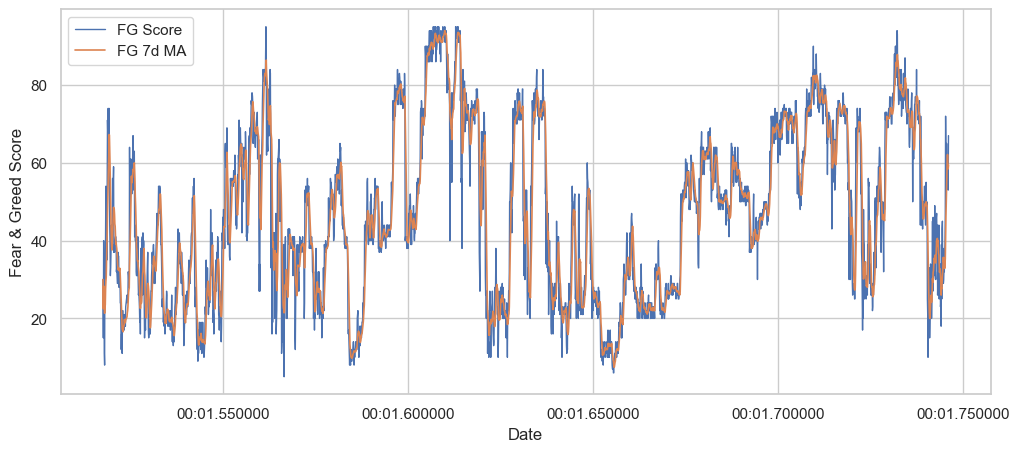

In [14]:
sns.set(style="whitegrid")

# 1. Time series: Score and trades_count
plt.figure(figsize=(12,5))
ax1 = plt.gca()
if 'Score' in df.columns:
    ax1.plot(df['Date'], df['Score'], label='FG Score', linewidth=1)
    ax1.plot(df['Date'], df['Score_7d'], label='FG 7d MA', linewidth=1.2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Fear & Greed Score')
ax1.legend(loc='upper left')

In [15]:
if 'trades_count' in df.columns:
    ax2 = ax1.twinx()
    ax2.bar(df['Date'], df['trades_count'], alpha=0.2, label='Trades Count', color='grey', width=4)
    ax2.set_ylabel('Trades Count')
    ax2.legend(loc='upper right')
plt.title('Fear & Greed Score vs Trades Count Over Time')
plt.tight_layout()
p1 = os.path.join(OUT_DIR, "score_vs_trades_time.png")
plt.savefig(p1, dpi=150)
plt.close()

In [16]:
if 'avg_closed_pnl' in df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df['Score'], df['avg_closed_pnl'], s=20, alpha=0.6)
    plt.xlabel('Fear & Greed Score')
    plt.ylabel('Avg Closed PnL')
    plt.title('Score vs Avg Closed PnL (Daily)')
    plt.tight_layout()
    p2 = os.path.join(OUT_DIR, "score_vs_avg_closed_pnl.png")
    plt.savefig(p2, dpi=150)
    plt.close()

In [17]:
if 'total_volume_usd' in df.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df['Score'], df['total_volume_usd'], s=20, alpha=0.6)
    plt.xlabel('Fear & Greed Score')
    plt.ylabel('Total Volume (USD)')
    plt.title('Score vs Total Volume (Daily)')
    plt.tight_layout()
    p3 = os.path.join(OUT_DIR, "score_vs_total_volume.png")
    plt.savefig(p3, dpi=150)
    plt.close()

In [18]:
if 'win_rate' in df.columns:
    plt.figure(figsize=(12,4))
    plt.plot(df['Date'], df['win_rate'], label='Win Rate', linewidth=1)
    plt.plot(df['Date'], df['win_rate_7d'], label='Win Rate 7d MA', linewidth=1.2)
    plt.xlabel('Date'); plt.ylabel('Win Rate')
    plt.title('Daily Win Rate Over Time')
    plt.legend()
    plt.tight_layout()
    p4 = os.path.join(OUT_DIR, "win_rate_time.png")
    plt.savefig(p4, dpi=150)
    plt.close()

In [19]:
corr_cols = [c for c in ['Score','trades_count','total_volume_usd','avg_closed_pnl','win_rate','avg_trade_size_usd'] if c in df.columns]
corr = df[corr_cols].corr(method='pearson')
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation Matrix')
p5 = os.path.join(OUT_DIR, "correlation_matrix.png")
plt.tight_layout()
plt.savefig(p5, dpi=150)
plt.close()


In [20]:
produced_plots = [p for p in [p1, locals().get('p2'), locals().get('p3'), locals().get('p4'), p5] if p]
# --- Generate PDF report ---
report_path = os.path.join(ROOT, "ds_report.pdf")
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=12)
pdf.add_page()
pdf.set_font("Arial", size=14)
pdf.cell(0,8, "Data Science Assignment — Web3 Trading Team", ln=True)
pdf.ln(3)
pdf.set_font("Arial", size=10)
pdf.multi_cell(0,6, "Candidate: Vishnu Vardhan\nProject: Relationship between trader behavior and market sentiment (Fear & Greed Index)\n\nThis report contains EDA, correlation analysis, and visualizations generated from the merged dataset.",)
pdf.ln(3)

In [21]:
pdf.set_font("Arial", size=11)
pdf.cell(0,6, "Summary statistics (selected):", ln=True)
pdf.ln(1)
desc = df[['Score']].describe().to_dict()
for k,v in desc['Score'].items():
    pdf.set_font("Arial", size=10)
    pdf.cell(0,5, f"  {k}: {v:.3f}", ln=True)
pdf.ln(3)

In [22]:
pdf.set_font("Arial", size=11)
pdf.cell(0,6, "Correlations with Fear & Greed Score:", ln=True)
pdf.ln(1)
if 'Score' in corr.columns:
    corr_with_score = corr['Score'].drop('Score').sort_values(ascending=False)
    for idx, val in corr_with_score.items():
        pdf.set_font("Arial", size=10)
        pdf.cell(0,5, f"  {idx}: {val:.3f}", ln=True)
pdf.ln(4)

In [ ]:
for img in produced_plots:
    if img and os.path.exists(img):
        try:
            pdf.add_page()
            pdf.set_font("Arial", size=12)
            title = os.path.basename(img).replace('_',' ').replace('.png','').title()
            pdf.cell(0,6, title, ln=True)
            pdf.ln(2)
            pdf.image(img, w=180)
            pdf.ln(2)
        except Exception as e:
            pdf.add_page()
            pdf.cell(0,6, f"Could not embed {img}: {e}", ln=True)
#pdf.output(report_path)